# Build extent-clipped (tile, basin, etc) stacks
#### used to tally and report biomass within masks (zones); eg. for landcovers
after building the extent-clipped stacks, analyze with extent_report.ipynb

In [ ]:
pip install contextily

In [1]:
# For some reason this is needed to get s3fs to work in ExtractUtils
# this upgrades to 0.3.4 even though we already specify this version in requirements_main...
#!pip install s3fs --upgrade
#!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
import s3fs
s3 = s3fs.S3FileSystem(anon=True)

In [4]:
try:
    import geopandas as gpd
    !pip install -U plotnine
except ModuleNotFoundError:
    print('Need to pip install packages...')
    !pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt

import matplotlib
import geopandas as gpd
import pandas as pd
import rasterio
import glob
import os
#import rioxarray
import fiona
from pyproj import CRS, Transformer

import sys
sys.path.append('/projects/icesat2_boreal/lib')
sys.path.append('/projects/code/icesat2_boreal/lib')
import ExtractUtils
import CovariateUtils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio
from rasterio.plot import show_hist, show
import numpy.ma as ma
from build_stack import *

from plotnine import *
import contextily as ctx
print("Importing packages complete.")
    
font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

Importing packages complete.


## Set up output directories, covars footprint vector, and tiles vector input

In [5]:
from mosaiclib import *

In [6]:
INDIR_MAIN = '/projects/my-public-bucket/databank'
# a writable outdir
OUTDIR_MAIN = '/projects/my-public-bucket/local_output/extent_stack_boreal_fire'
!mkdir -p $OUTDIR_MAIN
OUTDIR_CLIPS = os.path.join(OUTDIR_MAIN, 'output/build_stack_clips')
!mkdir -p $OUTDIR_CLIPS

# Setup access to ESA Worldcover s3 rasters
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# ESA Worldcover v100 2020
COVAR_FOOTPRINTS_FN = os.path.join(INDIR_MAIN,'footprints','footprints_v100_2020_v100_2020_map-s3.gpkg')

# Get boreal tiles to use CRS for reprojecting HYDROBASINS
boreal_tiles = gpd.read_file(boreal_tile_index_path)

https://gis.stackexchange.com/questions/345917/overlay-two-raster-geotiffs-using-rasterio-mask

#### Example: Get Worldcover covariate tiles

In [7]:
# Build a VRT of the LC on s3?
covar_footprint_tiles = gpd.read_file(COVAR_FOOTPRINTS_FN)
covar_footprint_tiles.head()

,footprint_name,path,file,s3_path,geometry
0,NaN,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E006_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((9.00000 0.00000, 9.00000 3.00000, 6...."
1,NaN,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E009_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((12.00000 0.00000, 12.00000 3.00000, ..."
2,NaN,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E012_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((15.00000 0.00000, 15.00000 3.00000, ..."
3,NaN,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E015_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((18.00000 0.00000, 18.00000 3.00000, ..."
4,NaN,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E018_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((21.00000 0.00000, 21.00000 3.00000, ..."


### Establish some broad DOMAIN in which to collect regions

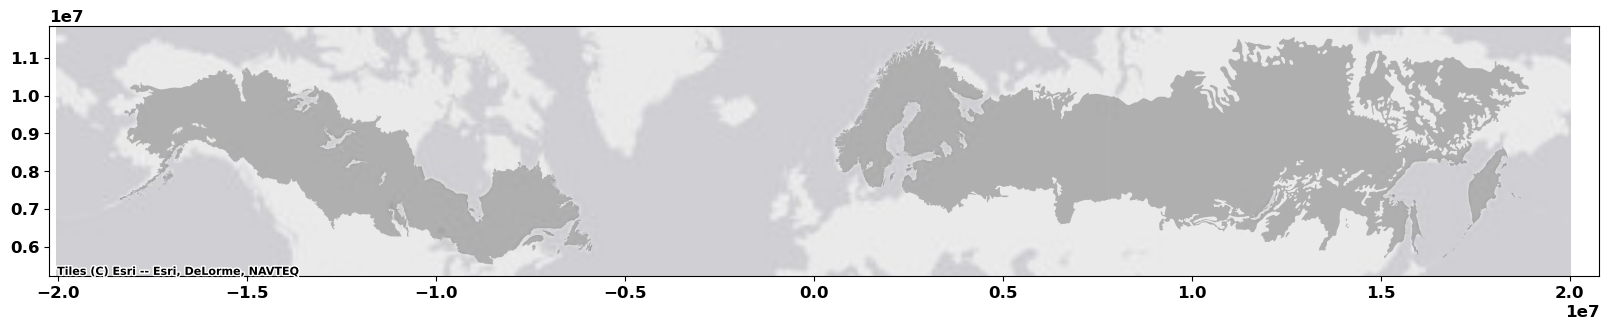

In [8]:
if False:
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )
    alaska = world[world.name == 'United States of America'].explode().cx[-170:-50, 50:90]
    canada = world[world.name == 'Canada']
    canada_alaska = pd.concat([alaska, canada])
    canada_alaska.plot()
    
# Get boreal domain from wwf 
boreal_gdf = gpd.read_file('/projects/shared-buckets/montesano/databank/arc/wwf_circumboreal_Dissolve.geojson')
ax = boreal_gdf.to_crs(3857).plot(alpha=0.25, color='black', figsize=(20,5))
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas)

### Subset covariate tiles by broad domain (boreal)
* Build the spatial selector with 'intersects'
* do the subset accord to region (where region is identified with the spatial selector)

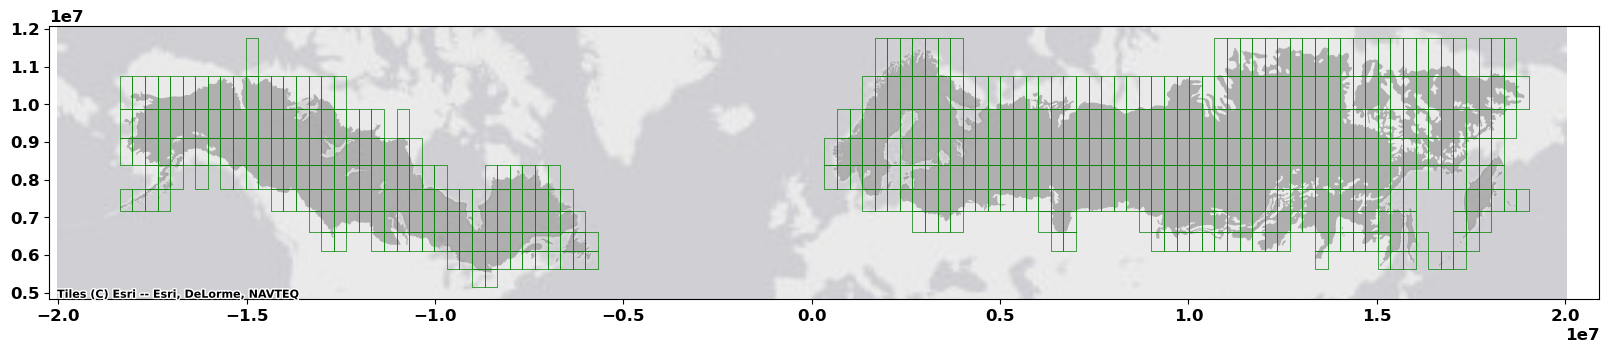

In [9]:
tile_group_region_string = 'wwf_boreal'

boreal_gdf['dissolve_field'] = 'for intersect'

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles.intersects(boreal_gdf.dissolve(by='dissolve_field').iloc[0].geometry)
covar_footprint_tiles_subset = covar_footprint_tiles[selector]
ax = covar_footprint_tiles_subset.to_crs(3857).boundary.plot(linewidth=0.5, color='green', figsize=(20,5))
ax = boreal_gdf.to_crs(3857).plot(alpha=0.25, color='black', ax=ax)
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas)

### Subset covariate tiles by sub-domain (eg, NA boreal)

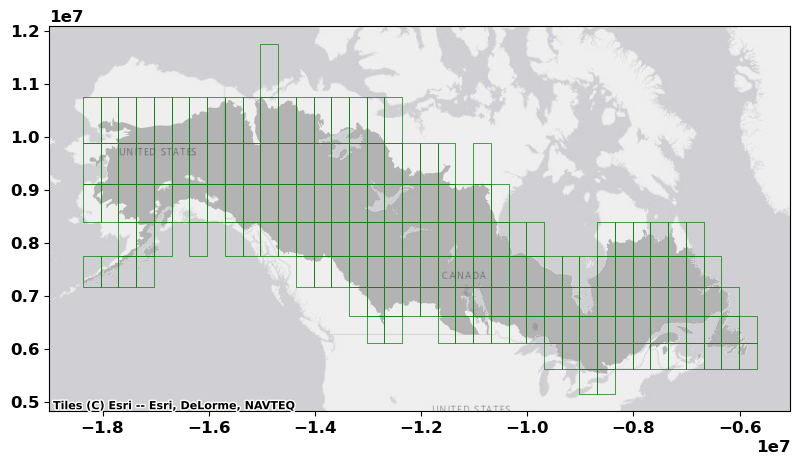

In [10]:
SUB_DOMAIN = 'america' #eurasia

tile_group_region_string = tile_group_region_string + '_' + SUB_DOMAIN

if 'america' in SUB_DOMAIN:
    xmin, xmax, ymin, ymax = [-179, -50, 30, 90]
if 'eurasia' in SUB_DOMAIN:
    xmin, xmax, ymin, ymax = [-20, 179, 30, 90]

SUB_DOMAIN_selection_geometry = boreal_gdf.cx[xmin:xmax, ymin:ymax].iloc[0].geometry

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles_subset.intersects(SUB_DOMAIN_selection_geometry)

covar_footprint_tiles_subset = covar_footprint_tiles_subset[selector]
ax = covar_footprint_tiles_subset.to_crs(3857).boundary.plot(linewidth=0.5, color='green', figsize=(20,5))
ax = boreal_gdf.cx[xmin:xmax, ymin:ymax].to_crs(3857).plot(alpha=0.25, color='black', ax=ax)
ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas)

In [11]:
# cog bands dict
bands_dict = {'1': 'esa_worldcover_v100_2020'
             }

### Subset the hydrobasins by sub domain (eg, all basins in NA boreal) 
this is just one of many vector files you can clip by - just requires some prep

In [12]:
if False:
    # Make GPKG of a merge all hydrobasin regions for a certain level
    NORTHERN_REGION_IDS = ['ar','as','eu','na','si']
    HYBAS_LEVEL_STR = 'lev06'
    OUT_HYBAS_NORTHERN_FN = os.path.join(OUTDIR_MAIN, 'input_zones', f'hybas_lake_NORTHERN_{HYBAS_LEVEL_STR}_{SUB_DOMAIN}_vc1.gpkg')

    if not os.path.isfile(OUT_HYBAS_NORTHERN_FN):
        print(f"Building and writing file: {OUT_HYBAS_NORTHERN_FN}")
        pd.concat([gpd.read_file(f).cx[xmin:xmax, ymin:ymax] for f in [glob.glob(f'/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_{hybas_reg}_{HYBAS_LEVEL_STR}_v1c.shp')[0] for hybas_reg in NORTHERN_REGION_IDS]]).to_file(OUT_HYBAS_NORTHERN_FN, driver='GPKG')
       # pd.concat([gpd.read_file(f) for f in glob.glob(f'/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_*_{HYBAS_LEVEL_STR}_v1c.shp')]).to_file(OUT_HYBAS_GLOBAL_FN, driver='GPKG')
    print(f"{OUT_HYBAS_NORTHERN_FN}")

## Choose type of extract extent

In [13]:
#### Hydrobasins L08 with TTE classes 

In [14]:
OUT_HYBAS_NORTHERN_FN = '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra.gpkg'
OUT_HYBAS_NORTHERN_FN
tile_group_region_string = 'tte_boreal_tundra'
HYBAS_LEVEL_STR = 'hydrobasins_L08_patterns_tte_boreal_tundra'

In [15]:
FIRE_POLYS_BOREAL_FN = '/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal.gpkg'
FIRE_POLYS_BOREAL_FN
# fires_gdf = gpd.read_parquet(FIRE_POLYS_BOREAL_FN)
# fires_gdf['year'] = fires_gdf['ig_year'].astype(str)
# fires_gdf.head()

'/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal.gpkg'

In [16]:
# import fiona
# fiona.listlayers(OUT_HYBAS_NORTHERN_FN)

In [17]:
# z = gpd.read_file(OUT_HYBAS_NORTHERN_FN)
# z.head()

### Establish and CHOOSE the clip INDEX_FN
vector polygon regions (specific basin, LVIS flightline, tile, etc within sub-domain)
* the GPKG that holds 1 specific clip polygon

In [18]:
CLIP_INDEX_DICT_LIST = [
    # Hydrobasins
    {
        'ID_COL_NAME': 'HYBAS_ID',
        'ID': None,#7060157640, #3060534340, #7060157640 4070084980 #4070000010,
        'ID_NAME': HYBAS_LEVEL_STR,
        'INDEX_LYR': None,
        'INDEX_FN': OUT_HYBAS_NORTHERN_FN, #f'/projects/my-public-bucket/analyze_agb/hydrobasins/{HYBAS_FILE}.shp'
        #'EXTENT_GDF': gpd.read_file(OUT_HYBAS_NORTHERN_FN),
        'ADD_STR': "-" + tile_group_region_string + '-reprj',
        'INDEX_REPRJ_FN': OUT_HYBAS_NORTHERN_FN.replace('.gpkg', "-" + tile_group_region_string + '-reprj' + '.gpkg')
    },
    # Fire Polys in Boreal
    {
        'ID_COL_NAME': 'id',
        'ID': 150725,
        'ID_NAME': 'earth_lab_firedpy',
        'INDEX_LYR': None,
        'INDEX_FN': FIRE_POLYS_BOREAL_FN, #f'/projects/my-public-bucket/analyze_agb/hydrobasins/{HYBAS_FILE}.shp',
        #'EXTENT_GDF': gpd.read_parquet(FIRE_POLYS_BOREAL_FN),
        'ADD_STR': '-boreal-reprj',
        'INDEX_REPRJ_FN': FIRE_POLYS_BOREAL_FN.replace('.parquet', '-boreal-reprj' + '.gpkg'),
        'CLIP_REPRJ_FN' : os.path.join(OUTDIR_MAIN, 'tmp', 'firedpy_boreal_reprj_clip.gpkg')
    },
    # Boreal tiles
    {
        'ID_COL_NAME': 'tile_num',
        'ID': 3459,
        'ID_NAME': 'boreal_tiles',
        'INDEX_LYR': None,
        'INDEX_FN': boreal_tile_index_path, #f'/projects/my-public-bucket/analyze_agb/hydrobasins/{HYBAS_FILE}.shp',
        #'EXTENT_GDF': gpd.read_parquet(FIRE_POLYS_BOREAL_FN),
        'ADD_STR': '-boreal-reprj',
        'INDEX_REPRJ_FN': boreal_tile_index_path.replace('.gpkg', '-boreal-reprj' + '.gpkg'),
        'CLIP_REPRJ_FN' : os.path.join(OUTDIR_MAIN, 'tmp', 'boreal_tiles_reprj_clip.gpkg')
    }
]

# Choose SPECIFIC dictionary with clip index vector (AOI) info

In [25]:
CLIP_INDEX_DICT = CLIP_INDEX_DICT_LIST[1]
CLIP_INDEX_DICT

{'ID_COL_NAME': 'id',
 'ID': 150725,
 'ID_NAME': 'earth_lab_firedpy',
 'INDEX_LYR': None,
 'INDEX_FN': '/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal.gpkg',
 'ADD_STR': '-boreal-reprj',
 'INDEX_REPRJ_FN': '/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal.gpkg',
 'CLIP_REPRJ_FN': '/projects/my-public-bucket/local_output/extent_stack_boreal_fire/tmp/firedpy_boreal_reprj_clip.gpkg'}

### Read and subset the clipping INDEX vector
update string variables used in BUILD_STACK

In [20]:
#z = CLIP_INDEX_DICT['EXTENT_GDF']
#z[CLIP_INDEX_DICT['ID_COL_NAME'] == CLIP_INDEX_DICT['ID']]

In [186]:
# gdf = gpd.read_parquet(FIRE_POLYS_BOREAL_FN)
# gdf[gdf[CLIP_INDEX_DICT['ID_COL_NAME']] == CLIP_INDEX_DICT['ID']].explore()

In [28]:
# For testing
gdf = gpd.read_file('/projects/my-public-bucket/local_output/extent_stack_boreal_fire/tmp/firedpy_boreal_reprj_clip.gpkg')
INDEX_FN = CLIP_INDEX_DICT['CLIP_REPRJ_FN']
INDEX_LYR = CLIP_INDEX_DICT['INDEX_LYR']

In [ ]:
if '.parquet' in CLIP_INDEX_DICT['INDEX_FN']:
    gdf = gpd.read_parquet(CLIP_INDEX_DICT['INDEX_FN'], )
else:
    gdf = gpd.read_file(CLIP_INDEX_DICT['INDEX_FN'], layer=CLIP_INDEX_DICT['INDEX_LYR'], bbox=(-150,-120,60,70))

In [ ]:

INPUT_CRS_UNITS = gdf.crs.axis_info[0].unit_name

if 'degree' in INPUT_CRS_UNITS:

    print('Reprojecting to equal area and writing reprojected output...')
    # Reproject hydrobasin SELECTION to equal area (boreal_tiles)
    gdf[gdf[CLIP_INDEX_DICT['ID_COL_NAME']] == CLIP_INDEX_DICT['ID']].to_crs(boreal_tiles.crs).to_file(CLIP_INDEX_DICT['CLIP_REPRJ_FN'], driver='GPKG', layer=CLIP_INDEX_DICT['INDEX_LYR'])

    # Read and plot the basin in orig prj
    #z = gpd.read_file(INDEX_FN).to_crs(4326)

    # Now change this variable back to what BUILD_STACK_DICT wants
    # Now you have INDEX_FN in the boreal_tiles crs
    INDEX_FN = CLIP_INDEX_DICT['CLIP_REPRJ_FN']
else:
    INDEX_FN = CLIP_INDEX_DICT['INDEX_FN']


# The INDEX_LYR comes off the INDEX_FN set just above...
if CLIP_INDEX_DICT['INDEX_LYR'] is None:
    print('Specify the layer name of the GPKG...')
    INDEX_LYR = os.path.split(INDEX_FN)[1].split('.gpkg')[0]
else:
    INDEX_LYR = CLIP_INDEX_DICT['INDEX_LYR']

print(f"\nDone updating file string input for build_stack():\n{INDEX_FN}\n{INDEX_LYR}")

### Get clip extent: randomly choose a feature (polygon) to examine and plot

Variables needed for input into BUILD_CLIP_DICT:
/projects/my-public-bucket/local_output/extent_stack_boreal_fire/tmp/firedpy_boreal_reprj_clip.gpkg
None
id
150725


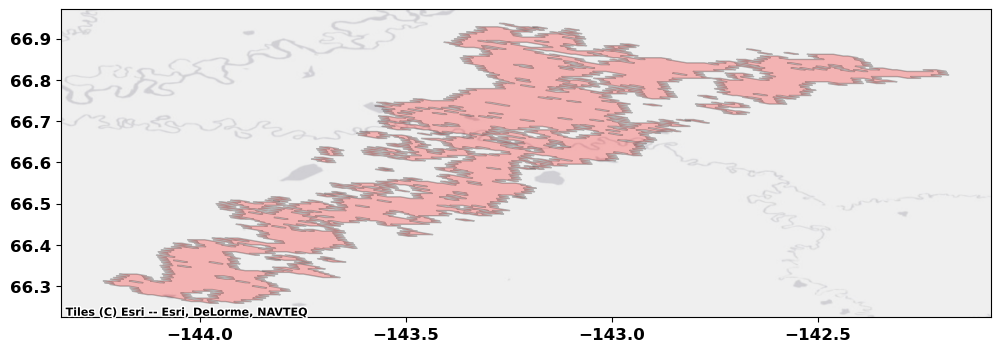

In [29]:
if CLIP_INDEX_DICT['ID'] is None:
    # Get random feature (HYBAS)
    TILE_NUM = gdf.sample(n=1)[CLIP_INDEX_DICT['ID_COL_NAME']].to_list()[0]
else:
    TILE_NUM = CLIP_INDEX_DICT['ID']
    

print('Variables needed for input into BUILD_CLIP_DICT:')
ID_COL_NAME = CLIP_INDEX_DICT['ID_COL_NAME']
print(INDEX_FN)
print(INDEX_LYR)
print(ID_COL_NAME)
print(TILE_NUM)

# Some extents will be near the -180 line and cause the plotting chunk to fail when doing the area calc.
# Try removing these polygons.
ax = gdf[ gdf[CLIP_INDEX_DICT['ID_COL_NAME']]==TILE_NUM  ].to_crs(4326).plot(color='red', alpha=0.25, ec='k', figsize=(12,8))
ax = ctx.add_basemap(ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas)
BAD_TILE_LIST = [3540,3634,3728,3823,3916,4004]

#### Plot clip extent within boreal 
This will fail if the TILE_NUM specified is NOT in the data frame

# Set list of dictionary inputs to stack
## Setup input using hydrobasin as clip INDEX_FN
* reprojected to equal area using boreal_tile_index
* so output has same res, crs, and clip extent

In [30]:
#BUILD_STACK_DICT = {'INDEX_FN':INDEX_FN,'ID_COL_NAME':ID_COL_NAME,'TILE_NUM':TILE_NUM,'INDEX_LYR':INDEX_LYR,'RASTER_NAME':'','COVAR_TILE_FN':'', 'IN_COVAR_S3_COL':'', 'NODATA_VAL':''}
DEFAULT_BUILD_STACK_DICT_LIST = [
    # ESA Worldcover 2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # Worldcover data is accessed via its footprint, with a 's3_path' col identifying the s3 locations of each tile
            'RASTER_NAME': 'esa_worldcover_v100_2020',
            'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints/footprints_v100_2020_v100_2020_map-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 0,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },
        # # Boreal Biomass c2020 (final)
        # {
        #     'INDEX_FN':INDEX_FN,
        #     'ID_COL_NAME':ID_COL_NAME,
        #     'TILE_NUM':TILE_NUM,
        #     'INDEX_LYR':INDEX_LYR,
        #     # AGB data is accessed
        #     # This needs to be correctly in 4326 - 
        #     'RASTER_NAME': 'biomass_final',
        #     'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/AGB/c2020/map_boreal_2022_rh_noground_v4/AGB_tindex_master.json',
        #     'IN_COVAR_S3_COL': 's3_path',
        #     'NODATA_VAL': -9999,
        #     'OUTPUT_CLIP_COG_FN':'',
        #     'CREDENTIALS_FN': None
        # },
    # # Boreal Stand Age 2020
    #     {
    #         'INDEX_FN':INDEX_FN,
    #         'ID_COL_NAME':ID_COL_NAME,
    #         'TILE_NUM':TILE_NUM,
    #         'INDEX_LYR':INDEX_LYR,
    #         # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
    #         'RASTER_NAME': 'standage',
    #         'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints_terrapulse-pub-data_forest_age_v2-s3.gpkg',
    #         'IN_COVAR_S3_COL': 's3_path',
    #         'NODATA_VAL': 255,
    #         'OUTPUT_CLIP_COG_FN':'',
    #         'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
    #     },
    # Boreal TCC 2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
            'RASTER_NAME': 'tcc2020',
            'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints/footprints_terrapulse-pub-data_tcc_2020-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 255,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        },
    # Boreal TCC rate of change (linear), 1984-2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
            'RASTER_NAME': 'tccslope',
            'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints/footprints_terrapulse-pub-data_tcc_slope-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 255,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        },
    # Boreal TCC rate of change (linear) p-value, 1984-2020
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
            'RASTER_NAME': 'tccpvalue',
            'COVAR_TILE_FN': f'{INDIR_MAIN}/footprints/footprints_terrapulse-pub-data_tcc_pvalue-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 255,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        }
]

DEFAULT_BUILD_STACK_DICT_LIST

[{'INDEX_FN': '/projects/my-public-bucket/local_output/extent_stack_boreal_fire/tmp/firedpy_boreal_reprj_clip.gpkg',
  'ID_COL_NAME': 'id',
  'TILE_NUM': 150725,
  'INDEX_LYR': None,
  'RASTER_NAME': 'esa_worldcover_v100_2020',
  'COVAR_TILE_FN': '/projects/my-public-bucket/databank/footprints/footprints_v100_2020_v100_2020_map-s3.gpkg',
  'IN_COVAR_S3_COL': 's3_path',
  'NODATA_VAL': 0,
  'OUTPUT_CLIP_COG_FN': '',
  'CREDENTIALS_FN': None},
 {'INDEX_FN': '/projects/my-public-bucket/local_output/extent_stack_boreal_fire/tmp/firedpy_boreal_reprj_clip.gpkg',
  'ID_COL_NAME': 'id',
  'TILE_NUM': 150725,
  'INDEX_LYR': None,
  'RASTER_NAME': 'tcc2020',
  'COVAR_TILE_FN': '/projects/my-public-bucket/databank/footprints/footprints_terrapulse-pub-data_tcc_2020-s3.gpkg',
  'IN_COVAR_S3_COL': 's3_path',
  'NODATA_VAL': 255,
  'OUTPUT_CLIP_COG_FN': '',
  'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'},
 {'INDEX_FN': '/projects/my-public-bucket/local_output/extent_stack_boreal_f

# Choose layers for stack

In [31]:
BUILD_STACK_DICT_LIST = DEFAULT_BUILD_STACK_DICT_LIST
BUILD_STACK_DICT_LIST

[{'INDEX_FN': '/projects/my-public-bucket/local_output/extent_stack_boreal_fire/tmp/firedpy_boreal_reprj_clip.gpkg',
  'ID_COL_NAME': 'id',
  'TILE_NUM': 150725,
  'INDEX_LYR': None,
  'RASTER_NAME': 'esa_worldcover_v100_2020',
  'COVAR_TILE_FN': '/projects/my-public-bucket/databank/footprints/footprints_v100_2020_v100_2020_map-s3.gpkg',
  'IN_COVAR_S3_COL': 's3_path',
  'NODATA_VAL': 0,
  'OUTPUT_CLIP_COG_FN': '',
  'CREDENTIALS_FN': None},
 {'INDEX_FN': '/projects/my-public-bucket/local_output/extent_stack_boreal_fire/tmp/firedpy_boreal_reprj_clip.gpkg',
  'ID_COL_NAME': 'id',
  'TILE_NUM': 150725,
  'INDEX_LYR': None,
  'RASTER_NAME': 'tcc2020',
  'COVAR_TILE_FN': '/projects/my-public-bucket/databank/footprints/footprints_terrapulse-pub-data_tcc_2020-s3.gpkg',
  'IN_COVAR_S3_COL': 's3_path',
  'NODATA_VAL': 255,
  'OUTPUT_CLIP_COG_FN': '',
  'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'},
 {'INDEX_FN': '/projects/my-public-bucket/local_output/extent_stack_boreal_f

## Run the extent clips of the rasters
#### Get the list of IDs

In [158]:
# import fiona
# fiona.listlayers(TTE_HYBAS_FN)


In [159]:
# TTE_HYBAS_FN = '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte.gpkg'
# TTE_HYBAS_FN = '/projects/my-public-bucket/databank/boreal_height_cmip6/hydrobasins_L08_patterns_tte_boreal_tundra.gpkg'
# hybas_L08_boreal_tte_tundra = gpd.read_file(TTE_HYBAS_FN ).to_crs(3995) #OUT_HYBAS_NORTHERN_FN
# HYBAS_ID_LIST = hybas_L08_boreal_tte_tundra.HYBAS_ID.to_list()

In [160]:
# hybas_L08_boreal_tte_tundra['area_sqkm'] = hybas_L08_boreal_tte_tundra.geometry.area / 1e6

In [161]:
# # z = hybas_L08_boreal_tte_tundra[hybas_L08_boreal_tte_tundra.area_sqkm < 0.01]
# # #hybas_L08_boreal_tte_tundra[hybas_L08_boreal_tte_tundra.HYBAS_ID == '7080026381'].head()#.plot()
# # ax = z.head(1).centroid.plot(markersize=1, color='red')
# # #hybas_L08_boreal_tte_tundra[hybas_L08_boreal_tte_tundra.HYBAS_ID == '7080019440'].plot(column='pattern_class', alpha=0.1, ax=ax, ec='black')
# hybas_L08_boreal_tte_tundra.head()

In [162]:
# df_smry = hybas_L08_boreal_tte_tundra.groupby(['HYBAS_ID']).aggregate({'pattern_class':'count',  'area_sqkm':'min'}).reset_index()
# dup_id_list = df_smry[df_smry.pattern_class > 1].HYBAS_ID.to_list()
# dup_id_list_mins_gt1 = df_smry[df_smry.pattern_class > 1][df_smry.area_sqkm > 1].HYBAS_ID.to_list()
# hybas_L08_boreal_tte_tundra[hybas_L08_boreal_tte_tundra.HYBAS_ID.isin(dup_id_list_mins_gt1)].dropna().explore(column='pattern_class')

In [32]:
OUTDIR_CLIPS

'/projects/my-public-bucket/local_output/extent_stack_boreal_fire/output/build_stack_clips'

In [35]:
gdf.crs

<Bound CRS: PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DAT ...>
Name: unnamed
Axis Info [cartesian]:
- [east]: Easting (Meter)
- [north]: Northing (Meter)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from GRS 1980(IUGG, 1980) to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: unknown
- Ellipsoid: GRS80
- Prime Meridian: Greenwich
Source CRS: unnamed

In [33]:
from multiprocessing import Pool
from functools import partial

In [34]:
BUILD_STACK_DICT_LIST[0]

{'INDEX_FN': '/projects/my-public-bucket/local_output/extent_stack_boreal_fire/tmp/firedpy_boreal_reprj_clip.gpkg',
 'ID_COL_NAME': 'id',
 'TILE_NUM': 150725,
 'INDEX_LYR': None,
 'RASTER_NAME': 'esa_worldcover_v100_2020',
 'COVAR_TILE_FN': '/projects/my-public-bucket/databank/footprints/footprints_v100_2020_v100_2020_map-s3.gpkg',
 'IN_COVAR_S3_COL': 's3_path',
 'NODATA_VAL': 0,
 'OUTPUT_CLIP_COG_FN': '',
 'CREDENTIALS_FN': None}

In [51]:
import importlib
import build_stack
importlib.reload(build_stack)

<module 'build_stack' from '/projects/code/icesat2_boreal/lib/build_stack.py'>

In [52]:
def multi_process_build_stack(ID, BUILD_STACK_DICT=BUILD_STACK_DICT_LIST[0], OUTDIR_CLIPS=OUTDIR_CLIPS):
    
    BUILD_STACK_DICT.update([('TILE_NUM', ID)])
    BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN'] = os.path.join( OUTDIR_CLIPS, f"{BUILD_STACK_DICT['RASTER_NAME']}_{BUILD_STACK_DICT['TILE_NUM']}_cog.tif")
    
    # # INDEX clip shapes should be in equal area
    # # COVAR_TILE_FN tiles (of raster COGs) should be in 4326
    # args = f"\
    # --in_tile_fn {BUILD_STACK_DICT['INDEX_FN']} \
    # --in_tile_id_col {BUILD_STACK_DICT['ID_COL_NAME']} \
    # --in_tile_num {BUILD_STACK_DICT['TILE_NUM']} \
    # --tile_buffer_m 0 \
    # --in_tile_layer {BUILD_STACK_DICT['INDEX_LYR']} \
    # -o {OUTDIR_CLIPS} \
    # --topo_off \
    # --covar_src_name {BUILD_STACK_DICT['RASTER_NAME']} \
    # --covar_tile_fn {BUILD_STACK_DICT['COVAR_TILE_FN']} \
    # --in_covar_s3_col {BUILD_STACK_DICT['IN_COVAR_S3_COL']} \
    # --input_nodata_value {BUILD_STACK_DICT['NODATA_VAL']} \
    # --clip" #<-- testing a clip to polygon
    # print(args,'\n')
    
    def run_build_stack():
        build_stack.build_stack_(
            stack_tile_fn =  BUILD_STACK_DICT['INDEX_FN'], 
            in_tile_id_col = BUILD_STACK_DICT['ID_COL_NAME'], 
            stack_tile_id =  BUILD_STACK_DICT['TILE_NUM'],
            tile_buffer_m = 0, 
            stack_tile_layer = BUILD_STACK_DICT['INDEX_LYR'],
            covar_tile_fn =   BUILD_STACK_DICT['COVAR_TILE_FN'],
            in_covar_s3_col = BUILD_STACK_DICT['IN_COVAR_S3_COL'], 
            res = 30, 
            input_nodata_value = BUILD_STACK_DICT['NODATA_VAL'],
            tmp_out_path = '/projects/tmp', 
            covar_src_name = BUILD_STACK_DICT['RASTER_NAME'],
            bandnames_list = [BUILD_STACK_DICT['RASTER_NAME']],
            band_indexes_list = None,
            clip = True, 
            topo_off = True, 
            output_dir = OUTDIR_CLIPS,
            height = None,
            width = None
           )
    if True:
        # Try without setting up an aws_session
        run_build_stack()
    else:
        if BUILD_STACK_DICT['CREDENTIALS_FN'] is not None:
            aws_session = CovariateUtils.get_rio_aws_session_from_creds(BUILD_STACK_DICT['CREDENTIALS_FN'])
            with rio.Env(aws_session):
                #!python /projects/Developer/icesat2_boreal/lib/build_stack.py $args
                run_build_stack()
        else:
            #!python /projects/Developer/icesat2_boreal/lib/build_stack.py $args
            run_build_stack()

In [ ]:
with Pool(processes=4) as pool:
    returned_stuff = pool.map(partial(multi_process_build_stack, BUILD_STACK_DICT = BUILD_STACK_DICT_LIST[0], OUTDIR_CLIPS = OUTDIR_CLIPS ), [3459])

In [53]:
with Pool(processes=4) as pool:
    returned_stuff = pool.map(partial(multi_process_build_stack, BUILD_STACK_DICT = BUILD_STACK_DICT_LIST[0], OUTDIR_CLIPS = OUTDIR_CLIPS ), [150725])

2 covariate filename(s) intersecting the 0 m buffered bbox for tile id 150725:

in_bbox: [1509911.148732054, 3344397.8098293967, 1559857.1118073782, 3441017.273722568]
Getting output height and width from buffered (buffer=0) original poly geometry...
3220 x 1664
Band indexes list: [1]
['esa_worldcover_v100_2020']
s3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N66W144_Map.tif
s3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N66W147_Map.tif
Mosaic shape: (1, 3220, 1664)
Mosaic bbox: [1509911.148732054, 3344397.8098293967, 1559857.1118073782, 3441017.273722568]
Writing stack as cloud-optimized geotiff: /projects/my-public-bucket/local_output/extent_stack_boreal_fire/output/build_stack_clips/esa_worldcover_v100_2020_150725_cog.tif
With clip=True, align=True; COG will align to the total bounds of the clip geom (tile) - since tile is in orig projection this clips to the tile extent.
Shape of input:			 (1, 3220, 1664)
Resampling:			 0	[0=nearest, 1=blinear, 2=cub

/projects/code/icesat2_boreal/lib/build_stack.py:336: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.


Current stack shape:		(1,1665,3221)


Reading input: <open WarpedVRT name='WarpedVRT(/vsimem/3fe2e6e4-eedf-48ac-94d0-3afe12d31381/3fe2e6e4-eedf-48ac-94d0-3afe12d31381.tif)' mode='r'>

Adding overviews...
Updating dataset tags...
Writing output to: /projects/my-public-bucket/local_output/extent_stack_boreal_fire/output/build_stack_clips/esa_worldcover_v100_2020_150725_cog.tif


Image written to disk:		 /projects/my-public-bucket/local_output/extent_stack_boreal_fire/output/build_stack_clips/esa_worldcover_v100_2020_150725_cog.tif
Removing tmp file: esa_worldcover_v100_2020_150725_cog.tif.msk


In [39]:
import rasterio

In [54]:
#fn_from_test_build_stack = '/projects/my-public-bucket/local_output/build_stack_test_fixed_cleaned_cog/esa_worldcover_v100_2020_3459_cog.tif'
fn_this_nb = '/projects/my-public-bucket/local_output/extent_stack_boreal_fire/output/build_stack_clips/esa_worldcover_v100_2020_150725_cog.tif'

In [55]:
#with rasterio.open(fn_from_test_build_stack) as src: rasterio.plot.show(src)

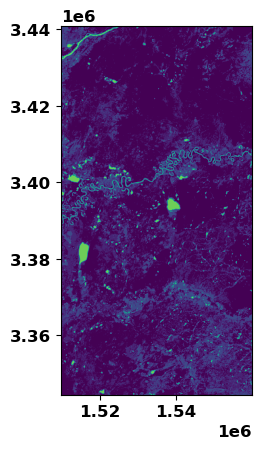

In [56]:
with rasterio.open(fn_this_nb) as src: rasterio.plot.show(src)

In [76]:
!pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 2.6 MB/s eta 0:00:00a 0:00:01


In [77]:
BUILD_STACK_DICT_LIST[0]['INDEX_FN']

'/projects/my-public-bucket/local_output/extent_stack_boreal_fire/tmp/firedpy_boreal_reprj_clip.gpkg'

In [87]:
CLIP_INDEX_DICT['INDEX_FN']

'/projects/my-public-bucket/databank/fire_perimeters/firedpy_boreal.parquet'

In [113]:
def rename_columns(GDF, bandname, stats_list):
    if stats_list is not None:
       
        names_list = ['val_'+ bandname + '_' + s for s in stats_list]
        rename_dict = dict(zip(stats_list, names_list))      
        GDF = GDF.rename(columns = rename_dict)
        
    return GDF

def extract_zonal_gdf_poly(ID, bandnames: list, GDF_fn = CLIP_INDEX_DICT['INDEX_FN'], ndval=255, 
                           stats_list = ['max','min','median','mean','percentile_02','percentile_25','percentile_75','percentile_98','count']):
    
    #r_fn = f'/projects/my-public-bucket/databank/boreal_height_cmip6/output/build_stack_basin_clips/tccpvalue_{HYBAS_ID}_cog.tif'
    r_fn = f'/projects/my-public-bucket/local_output/extent_stack_boreal_fire/output/build_stack_clips/tcc2020_{ID}_cog.tif'
    
    if '.parquet' in CLIP_INDEX_DICT['INDEX_FN']:
        GDF = gpd.read_parquet(GDF_fn)
    else:
        GDF = gpd.read_file(GDF_fn)
        
    GDF = GDF[GDF[CLIP_INDEX_DICT['ID_COL_NAME']] == ID]
    
    from rasterstats import zonal_stats
    import numpy as np
    
    gdf_list = []
    
    with rasterio.open(r_fn) as r_src:
        print("\tExtracting raster values from: ", r_fn)

        for i, bandname in enumerate(bandnames):
            
            bnum = i + 1
            print(bnum)
            
            # Get array
            array = r_src.read(bnum)
            array = array.astype('float64')
            array[array==ndval] = np.nan
            df = pd.DataFrame(
                    zonal_stats(
                        vectors=GDF.to_crs(r_src.crs), 
                        raster= array,#r_src.read(bnum, masked=True),
                        affine= r_src.transform,
                        stats=stats_list
                    )
            )

            # Rename cols
            df = rename_columns(df, bandname, stats_list)

            final_gdf = GDF.reset_index().join(df.reset_index(drop=True), how='left')
            gdf_list.append(final_gdf)
            
        # Write the table of zonal stats on each band for current HYBAS_ID   
        extent_id_gdf = pd.concat(gdf_list)
        extent_id_gdf.to_file(r_fn.split('.tif')[0] + '_zonalstats.gpkg', driver = 'GPKG')
    
    return pd.concat(gdf_list)

# z = extract_zonal_gdf_poly(r_fn, GDF[GDF.HYBAS_ID == HYBAS_ID].iloc[[0]], bandnames=['tcc_slope'], reproject=False)
# z

In [116]:
with Pool(processes=4) as pool:
    returned_stuff = pool.map(partial(extract_zonal_gdf_poly, bandnames = ['tcc2020'], GDF_fn = CLIP_INDEX_DICT['INDEX_FN'] ), [150725])

	Extracting raster values from:  /projects/my-public-bucket/local_output/extent_stack_boreal_fire/output/build_stack_clips/tcc2020_150725_cog.tif
1


/opt/conda/envs/pangeo/lib/python3.10/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly


In [117]:
pd.concat(returned_stuff)

,level_0,index,fid,id,ig_date,ig_day,ig_month,ig_year,last_date,event_dur,...,geometry,val_tcc2020_max,val_tcc2020_min,val_tcc2020_median,val_tcc2020_mean,val_tcc2020_percentile_02,val_tcc2020_percentile_25,val_tcc2020_percentile_75,val_tcc2020_percentile_98,val_tcc2020_count
0,1176739,1176739,109097,150725,2019-06-22,173.0,6.0,2019.0,2019-08-16,56.0,...,"MULTIPOLYGON (((-143.96556 66.25832, -143.9759...",None,None,None,None,None,None,None,None,0


In [118]:
# # For each clip INDEX (polygon) there are 2 corresponding output clipped COGs you need
# BASIN_COG_DICT = {'landcover_cog_fn': '', 'biomass_cog_fn':'', 'standage_cog_fn':'', 'extent_gdf_fn': extent_gdf_fn}

# for BUILD_STACK_DICT in BUILD_STACK_DICT_LIST:
#     if 'worldcover' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
#         BASIN_COG_DICT.update({'landcover_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
#     if 'biomass' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
#         BASIN_COG_DICT.update({'biomass_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
#     if 'standage' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
#         BASIN_COG_DICT.update({'standage_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
#     if 'tcc2020' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
#         BASIN_COG_DICT.update({'tcc2020_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
#     if 'tccslope' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
#         BASIN_COG_DICT.update({'tccslope_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
#     if 'tccpvalue' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
#         BASIN_COG_DICT.update({'tccpvalue_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
# BASIN_COG_DICT